# 패키지 import

In [1]:
### 필요 패키지 import ###
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, notebook

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print(torch.__version__)

1.10.1


# Data Load

In [3]:
seed = 7

classes_names = ["포트홀 없음", "포트홀", "보수 완료된 포트홀"]
train_data = pd.read_csv("Train_datasets_labels.csv")
valid_data = pd.read_csv("Validation_datasets_labels.csv")


train_data = train_data.sample(frac=1, random_state=seed).reset_index(drop=True)
valid_data = valid_data.sample(frac=1, random_state=seed).reset_index(drop=True)

print(len(train_data))
print(len(valid_data))

23389
300


Label : 포트홀


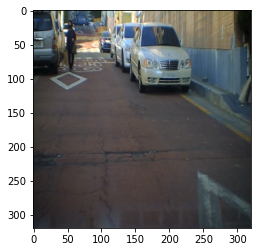

In [4]:
# Train
idx = 15910

print("Label :", classes_names[train_data.iloc[idx, 1]])

img = Image.open(train_data.iloc[idx,0])
plt.imshow(img)

Label : 포트홀


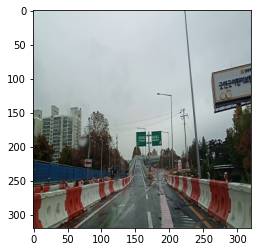

In [5]:
# Valid
idx = 261

print("Label :", classes_names[valid_data.iloc[idx, 1]])

img = Image.open(valid_data.iloc[idx,0])
plt.imshow(img)

# Define Data-Sets

In [6]:
class MyDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.df.iloc[idx][0]
        img = np.array(PIL.Image.open(self.df.iloc[idx][0])) / 255.
        label = torch.tensor(self.df.iloc[idx][1])
        
        img = np.transpose(torch.tensor(img).float(),(2, 0, 1))
        label = F.one_hot(label, num_classes=3).float()
        
        return img, label
    
train = MyDataset(train_data)
train_loader = DataLoader(train, batch_size = 32)

valid = MyDataset(valid_data)
valid_loader = DataLoader(valid, batch_size = 32)

In [7]:
img, label = train.__getitem__(0)

print(img.shape)
print(label.shape)

torch.Size([3, 320, 320])
torch.Size([3])


포트홀


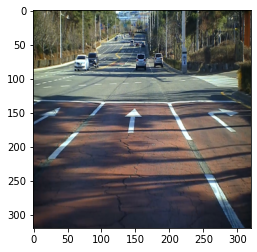

In [8]:
img, label = train.__getitem__(294)

_, label = torch.max(label, dim=0)
img = np.transpose(img, (1,2,0))

print(classes_names[label])
plt.imshow(img)

포트홀


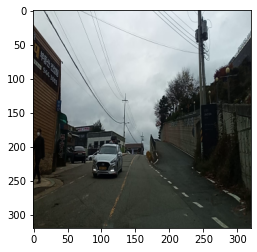

In [9]:
img, label = valid.__getitem__(294)

_, label = torch.max(label, dim=0)
img = np.transpose(img, (1,2,0))

print(classes_names[label])
plt.imshow(img)

# Define Train,Valid Function

In [10]:
loss_fn = nn.CrossEntropyLoss()

def calc_acc(X, Y):
    x_val, x_idx = torch.max(X, dim=1)
    y_val, y_idx = torch.max(Y, dim=1)
    return (x_idx == y_idx).sum().item()

def train(EPOCHS, model, train_loader, valid_loader, opt):
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    for epoch in range(1, EPOCHS+1):
        model.train()
        train_acc = 0
        print("<<< EPOCH {} >>>".format(epoch))
        for batch_idx, (img,label) in enumerate(notebook.tqdm(train_loader)):
            img, label = img.to(DEVICE), label.to(DEVICE)
            
            output = model(img)                 # 순전파
            loss = loss_fn(output, label)       # 오차 계산
            
            opt.zero_grad()                     # opt내부 값 초기화
            loss.backward()                     # 오차 역전파
            opt.step()                          # 가중치 갱신
            
            train_acc += calc_acc(output, label)
            if batch_idx % 100 == 0 and batch_idx != 0:
                print("Training : [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Acc : {:.3f}".format(
                    batch_idx * len(img), 
                    len(train_loader.dataset), 
                    100. * batch_idx / len(train_loader), 
                    loss.item(),
                    train_acc / len(train_loader.dataset)))
                
        print("Training : [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Acc : {:.3f}".format(
                    len(train_loader.dataset), 
                    len(train_loader.dataset), 
                    100. * batch_idx / len(train_loader), 
                    loss.item(),
                    train_acc / len(train_loader.dataset)))
        t_loss, t_acc = evaluate(model, valid_loader)
        print("[{}] Test Loss : {:.4f}\t accuracy: {:.2f}%\n".format(epoch, t_loss, t_acc*100.))

        train_loss_history.append(loss)
        train_acc_history.append(train_acc / len(train_loader.dataset))

        valid_loss_history.append(t_loss)
        valid_acc_history.append(t_acc)

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history
                
def evaluate(model, valid_loader):
    model.eval()
    t_loss = 0
    correct = 0
    
    with torch.no_grad():
        for img, label in notebook.tqdm(valid_loader):
            img, label = img.to(DEVICE), label.to(DEVICE)
            
            output = model(img)
            t_loss += loss_fn(output, label)
            
            correct += calc_acc(output, label)

    t_loss /= len(valid_loader)
    t_acc = correct / len(valid_loader.dataset)
    return t_loss, t_acc

# Define Model

In [11]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

print(USE_CUDA)
print(DEVICE)

True
cuda


In [12]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.bn = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 3)

        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.AdaptiveAvgPool2d(1)
        self.act_fn = nn.ReLU()

        self.drop = nn.Dropout(p = 0.25)
        
    def forward(self, x):
        x = self.conv1(x)           # (batch, 3, 320, 320) -> (batch, 16, 320, 320)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 16, 320, 320) -> (batch, 16, 160, 160)

        x = self.conv2(x)           # (batch, 16, 160, 160) -> (batch, 32, 160 ,160)
        x = self.bn(x)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 32, 160, 160) -> (batch, 32, 80, 80)
        
        x = self.conv3(x)           # (batch, 32, 80, 80) -> (batch, 64, 80, 80)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 64, 80, 80) -> (batch, 64, 40, 40)

        x = self.conv4(x)           # (batch, 64, 40, 40) -> (batch, 128, 40, 40)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 128, 40, 40) -> (batch, 128, 20, 20)

        x = self.flatten(x)         # (batch, 128, 20, 20) -> (batch, 128, 1, 1)
        x = x.view(-1, 128*1*1)     # (batch, 128, 1, 1) -> (batch, 128)

        x = self.fc1(x)             # (batch, 128) -> (batch, 32)
        x = self.act_fn(x)
        x = self.drop(x)

        x = self.fc2(x)              # (batch, 32) -> (batch, 3)
        return x

In [13]:
model = MyModel().to(DEVICE)

opt = optim.AdamW(model.parameters(), lr = 0.001)
print("DEVICE: ", DEVICE)
print("MODEL: ", model)
print("model's number of Parameters: ", sum([p.numel() for p in model.parameters()]))

DEVICE:  cuda
MODEL:  MyModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): AdaptiveAvgPool2d(output_size=1)
  (act_fn): ReLU()
  (drop): Dropout(p=0.25, inplace=False)
)
model's number of Parameters:  101731


In [14]:
t_loss_his, t_acc_his, v_loss_his, v_acc_his = train(EPOCHS = 10, model = model, train_loader = train_loader, valid_loader = valid_loader, opt = opt)

<<< EPOCH 1 >>>


  0%|          | 0/731 [00:00<?, ?it/s]

Training : [3200/23389 (14%)]	Loss: 0.828010	 Acc : 0.072
Training : [6400/23389 (27%)]	Loss: 0.883232	 Acc : 0.154
Training : [9600/23389 (41%)]	Loss: 0.745002	 Acc : 0.238
Training : [12800/23389 (55%)]	Loss: 0.736879	 Acc : 0.324
Training : [16000/23389 (68%)]	Loss: 0.736956	 Acc : 0.411
Training : [19200/23389 (82%)]	Loss: 0.801818	 Acc : 0.500
Training : [22400/23389 (96%)]	Loss: 0.748906	 Acc : 0.587
Training : [23389/23389 (100%)]	Loss: 0.645083	 Acc : 0.614


  0%|          | 0/10 [00:00<?, ?it/s]

[1] Test Loss : 1.1659	 accuracy: 38.00%

<<< EPOCH 2 >>>


  0%|          | 0/731 [00:00<?, ?it/s]

Training : [3200/23389 (14%)]	Loss: 0.831409	 Acc : 0.088
Training : [6400/23389 (27%)]	Loss: 0.842244	 Acc : 0.176
Training : [9600/23389 (41%)]	Loss: 0.673381	 Acc : 0.267
Training : [12800/23389 (55%)]	Loss: 0.773265	 Acc : 0.357
Training : [16000/23389 (68%)]	Loss: 0.715327	 Acc : 0.448
Training : [19200/23389 (82%)]	Loss: 0.687454	 Acc : 0.540
Training : [22400/23389 (96%)]	Loss: 0.696005	 Acc : 0.631
Training : [23389/23389 (100%)]	Loss: 0.510283	 Acc : 0.658


  0%|          | 0/10 [00:00<?, ?it/s]

[2] Test Loss : 1.0093	 accuracy: 39.33%

<<< EPOCH 3 >>>


  0%|          | 0/731 [00:00<?, ?it/s]

Training : [3200/23389 (14%)]	Loss: 0.728129	 Acc : 0.092
Training : [6400/23389 (27%)]	Loss: 0.614403	 Acc : 0.183
Training : [9600/23389 (41%)]	Loss: 0.630637	 Acc : 0.278
Training : [12800/23389 (55%)]	Loss: 0.547240	 Acc : 0.370
Training : [16000/23389 (68%)]	Loss: 0.632959	 Acc : 0.465
Training : [19200/23389 (82%)]	Loss: 0.649827	 Acc : 0.560
Training : [22400/23389 (96%)]	Loss: 0.639085	 Acc : 0.654
Training : [23389/23389 (100%)]	Loss: 0.505601	 Acc : 0.682


  0%|          | 0/10 [00:00<?, ?it/s]

[3] Test Loss : 1.0278	 accuracy: 43.00%

<<< EPOCH 4 >>>


  0%|          | 0/731 [00:00<?, ?it/s]

Training : [3200/23389 (14%)]	Loss: 0.690898	 Acc : 0.095
Training : [6400/23389 (27%)]	Loss: 0.496388	 Acc : 0.187
Training : [9600/23389 (41%)]	Loss: 0.488078	 Acc : 0.285
Training : [12800/23389 (55%)]	Loss: 0.552107	 Acc : 0.381
Training : [16000/23389 (68%)]	Loss: 0.655888	 Acc : 0.477
Training : [19200/23389 (82%)]	Loss: 0.630945	 Acc : 0.576
Training : [22400/23389 (96%)]	Loss: 0.661117	 Acc : 0.671
Training : [23389/23389 (100%)]	Loss: 0.512883	 Acc : 0.699


  0%|          | 0/10 [00:00<?, ?it/s]

[4] Test Loss : 1.0207	 accuracy: 43.67%

<<< EPOCH 5 >>>


  0%|          | 0/731 [00:00<?, ?it/s]

Training : [3200/23389 (14%)]	Loss: 0.632269	 Acc : 0.096
Training : [6400/23389 (27%)]	Loss: 0.440501	 Acc : 0.192
Training : [9600/23389 (41%)]	Loss: 0.429881	 Acc : 0.290
Training : [12800/23389 (55%)]	Loss: 0.462519	 Acc : 0.387
Training : [16000/23389 (68%)]	Loss: 0.593662	 Acc : 0.486
Training : [19200/23389 (82%)]	Loss: 0.655861	 Acc : 0.586
Training : [22400/23389 (96%)]	Loss: 0.560439	 Acc : 0.683
Training : [23389/23389 (100%)]	Loss: 0.527863	 Acc : 0.713


  0%|          | 0/10 [00:00<?, ?it/s]

[5] Test Loss : 1.0308	 accuracy: 55.00%

<<< EPOCH 6 >>>


  0%|          | 0/731 [00:00<?, ?it/s]

Training : [3200/23389 (14%)]	Loss: 0.627134	 Acc : 0.098
Training : [6400/23389 (27%)]	Loss: 0.492442	 Acc : 0.195
Training : [9600/23389 (41%)]	Loss: 0.471691	 Acc : 0.294
Training : [12800/23389 (55%)]	Loss: 0.512559	 Acc : 0.391
Training : [16000/23389 (68%)]	Loss: 0.538105	 Acc : 0.490
Training : [19200/23389 (82%)]	Loss: 0.627787	 Acc : 0.591
Training : [22400/23389 (96%)]	Loss: 0.526661	 Acc : 0.691
Training : [23389/23389 (100%)]	Loss: 0.471592	 Acc : 0.721


  0%|          | 0/10 [00:00<?, ?it/s]

[6] Test Loss : 1.0451	 accuracy: 51.67%

<<< EPOCH 7 >>>


  0%|          | 0/731 [00:00<?, ?it/s]

Training : [3200/23389 (14%)]	Loss: 0.622918	 Acc : 0.098
Training : [6400/23389 (27%)]	Loss: 0.488545	 Acc : 0.196
Training : [9600/23389 (41%)]	Loss: 0.451583	 Acc : 0.296
Training : [12800/23389 (55%)]	Loss: 0.490440	 Acc : 0.396
Training : [16000/23389 (68%)]	Loss: 0.526819	 Acc : 0.497
Training : [19200/23389 (82%)]	Loss: 0.557847	 Acc : 0.599
Training : [22400/23389 (96%)]	Loss: 0.546097	 Acc : 0.698
Training : [23389/23389 (100%)]	Loss: 0.465017	 Acc : 0.727


  0%|          | 0/10 [00:00<?, ?it/s]

[7] Test Loss : 0.9538	 accuracy: 59.67%

<<< EPOCH 8 >>>


  0%|          | 0/731 [00:00<?, ?it/s]

Training : [3200/23389 (14%)]	Loss: 0.598700	 Acc : 0.099
Training : [6400/23389 (27%)]	Loss: 0.454388	 Acc : 0.196
Training : [9600/23389 (41%)]	Loss: 0.455092	 Acc : 0.297
Training : [12800/23389 (55%)]	Loss: 0.433442	 Acc : 0.395
Training : [16000/23389 (68%)]	Loss: 0.538210	 Acc : 0.497
Training : [19200/23389 (82%)]	Loss: 0.509079	 Acc : 0.599
Training : [22400/23389 (96%)]	Loss: 0.536471	 Acc : 0.699
Training : [23389/23389 (100%)]	Loss: 0.446742	 Acc : 0.729


  0%|          | 0/10 [00:00<?, ?it/s]

[8] Test Loss : 0.9891	 accuracy: 56.00%

<<< EPOCH 9 >>>


  0%|          | 0/731 [00:00<?, ?it/s]

Training : [3200/23389 (14%)]	Loss: 0.632525	 Acc : 0.099
Training : [6400/23389 (27%)]	Loss: 0.456576	 Acc : 0.198
Training : [9600/23389 (41%)]	Loss: 0.430086	 Acc : 0.299
Training : [12800/23389 (55%)]	Loss: 0.479037	 Acc : 0.399
Training : [16000/23389 (68%)]	Loss: 0.511789	 Acc : 0.501
Training : [19200/23389 (82%)]	Loss: 0.613408	 Acc : 0.604
Training : [22400/23389 (96%)]	Loss: 0.487107	 Acc : 0.705
Training : [23389/23389 (100%)]	Loss: 0.467193	 Acc : 0.735


  0%|          | 0/10 [00:00<?, ?it/s]

[9] Test Loss : 1.0355	 accuracy: 57.67%

<<< EPOCH 10 >>>


  0%|          | 0/731 [00:00<?, ?it/s]

Training : [3200/23389 (14%)]	Loss: 0.598251	 Acc : 0.102
Training : [6400/23389 (27%)]	Loss: 0.486823	 Acc : 0.202
Training : [9600/23389 (41%)]	Loss: 0.431041	 Acc : 0.303
Training : [12800/23389 (55%)]	Loss: 0.407533	 Acc : 0.404
Training : [16000/23389 (68%)]	Loss: 0.497047	 Acc : 0.506
Training : [19200/23389 (82%)]	Loss: 0.544987	 Acc : 0.610
Training : [22400/23389 (96%)]	Loss: 0.448607	 Acc : 0.711
Training : [23389/23389 (100%)]	Loss: 0.451268	 Acc : 0.742


  0%|          | 0/10 [00:00<?, ?it/s]

[10] Test Loss : 0.9094	 accuracy: 57.67%



In [15]:
result = evaluate(model, valid_loader)
print("Loss : {:.4f}\t acc : {:.2f}".format(result[0], result[1]))

  0%|          | 0/10 [00:00<?, ?it/s]

Loss : 0.9094	 acc : 0.58


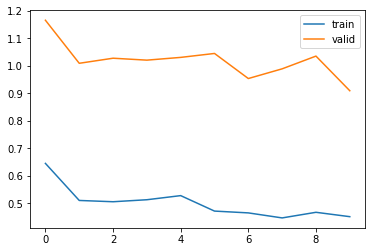

In [18]:
plt.plot(torch.tensor(t_loss_his), label="train")
plt.plot(torch.tensor(v_loss_his), label="valid")
plt.legend()
plt.show()

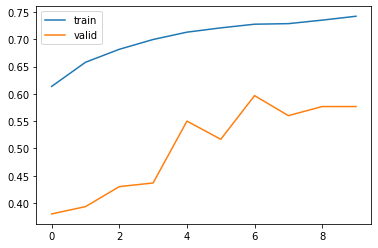

In [19]:
plt.plot(torch.tensor(t_acc_his), label="train")
plt.plot(torch.tensor(v_acc_his), label="valid")
plt.legend()
plt.show()